In [2]:
import torch
from torchvision import transforms
from process_data import load_vocab, create_dataloaders


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_PATH = "../data/final_combined_ds_tokenized.csv"
VOCAB_PATH = "../data/vocab_vi_underthesea.json"
DATA_ROOT = "../data"

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = create_dataloaders(
    csv_path=CSV_PATH,
    vocab_path=VOCAB_PATH,
    data_root=DATA_ROOT
)

stoi, itos = load_vocab(VOCAB_PATH)
vocab_size = len(stoi)
pad_idx = stoi["<pad>"]
bos_idx = stoi["<bos>"]
eos_idx = stoi["<eos>"]
unk_idx = stoi["<unk>"]

print(f"\nDATASET INFO:")
print(f"  Vocab size: {vocab_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Pad/BOS/EOS: {pad_idx}/{bos_idx}/{eos_idx}\n")

e:\hk5\deep_learning\assignments\ViT-Transformer-Caption-VN\src\process_data.py:44: DtypeWarning: Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, sep=sep)
e:\hk5\deep_learning\assignments\ViT-Transformer-Caption-VN\src\process_data.py:44: DtypeWarning: Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, sep=sep)



DATASET INFO:
  Vocab size: 4062
  Train batches: 1546
  Val batches: 191
  Pad/BOS/EOS: 0/1/2



e:\hk5\deep_learning\assignments\ViT-Transformer-Caption-VN\src\process_data.py:44: DtypeWarning: Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, sep=sep)


In [3]:
from vit_lstm_attention import ViT_LSTM_Attention


vit_lstm_attention = ViT_LSTM_Attention(
    vocab_size=vocab_size,
    embed_dim=512,
    hidden_dim=512,
    attention_dim=256,
    unfreeze_layers=2,
    dropout=0.3
).to(DEVICE)

BEST_MODEL_PATH = "../results/vit_lstm_attention.pth"
state_dict = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
vit_lstm_attention.load_state_dict(state_dict)

print("Đã load model:", BEST_MODEL_PATH)

d:\App\Miniconda\envs\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Admin\AppData\Local\Temp\ipykernel_23528\869209992.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for

Đã load model: ../results/vit_lstm_attention.pth


In [ ]:
from evaluate import generate_captions_for_dataset, compute_bleu_meteor, compute_cider


test_refs, test_hyps = generate_captions_for_dataset(
    model=vit_lstm_attention,
    base_dataset=test_ds,
    device=DEVICE,
    bos_idx=bos_idx,
    eos_idx=eos_idx,
    pad_idx=pad_idx,
)

metrics = compute_bleu_meteor(test_refs, test_hyps)
try:
    cider_score = compute_cider(test_refs, test_hyps)
    metrics["CIDEr"] = cider_score
except Exception as e:
    print("Error computing CIDEr:", e)

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

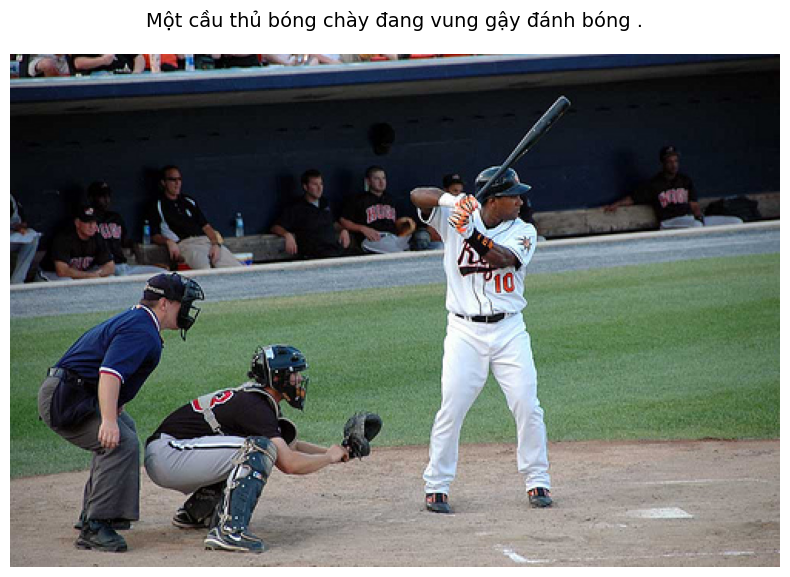

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
from evaluate import decode_tokens


def predict_caption(image_path, model, max_len=30):    
    model.eval()

    # 1. Load ảnh
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # 2. Generate
    with torch.no_grad():
        out_ids = model.generate_beam(
            images=img_tensor,
            bos_idx=bos_idx,
            eos_idx=eos_idx,
            max_len=max_len
        )

    # 3. Decode ra chữ
    caption = decode_tokens(
        token_ids=out_ids,
        itos=itos,
        eos_idx=eos_idx,
        bos_idx=bos_idx,
        pad_idx=pad_idx
    )
    caption = " ".join(caption).replace("_", " ")
    
    # 4. Hiển thị
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption, fontsize=14, wrap=True, pad=20)
    plt.tight_layout()
    plt.show()

IMAGE_PATH = "test.jpg"

predict_caption(IMAGE_PATH, vit_lstm_attention)